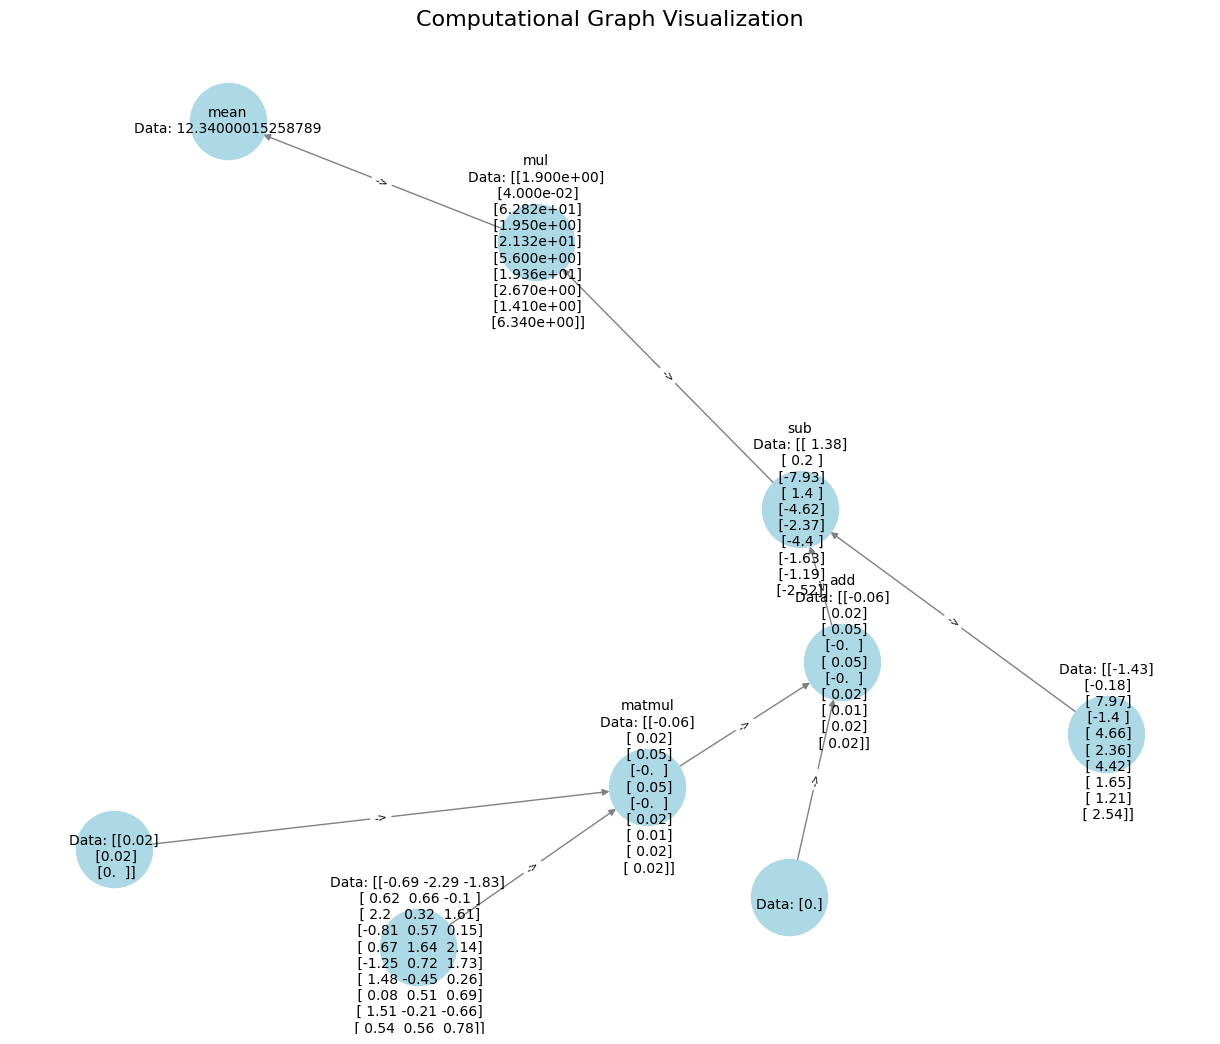

In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class Tensor:
    def __init__(self, data, requires_grad=False):
        self.data = np.array(data, dtype=np.float32)
        self.requires_grad = requires_grad
        self.grad = np.zeros_like(self.data) if requires_grad else None
        self._backward = lambda: None
        self._prev = set()
        self._op = ""


    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        topo_order = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for parent in v._prev:
                    build_topo(parent)
                topo_order.append(v)

        build_topo(self)

        for v in reversed(topo_order):
            v._backward()

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, requires_grad=self.requires_grad or other.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + out.grad
            if other.requires_grad:
                other.grad = other.grad + out.grad

        out._backward = _backward
        out._prev = {self, other}
        out._op = "add"
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, requires_grad=self.requires_grad or other.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + other.data * out.grad
            if other.requires_grad:
                other.grad = other.grad + self.data * out.grad

        out._backward = _backward
        out._prev = {self, other}
        out._op = "mul"
        return out

    def __pow__(self, power):
        assert isinstance(power, (int, float)), "Power must be scalar."
        out = Tensor(self.data**power, requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + power * (self.data**(power - 1)) * out.grad

        out._backward = _backward
        out._prev = {self}
        out._op = "pow"
        return out

    def exp(self):
        out = Tensor(np.exp(self.data), requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + out.data * out.grad

        out._backward = _backward
        out._prev = {self}
        out._op = "exp"
        return out

    def log(self):
        out = Tensor(np.log(self.data), requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + (1 / self.data) * out.grad

        out._backward = _backward
        out._prev = {self}
        out._op = "log"
        return out

    def clip_grad(self, max_norm):
        if self.grad is not None:
            norm = np.linalg.norm(self.grad)
            if norm > max_norm:
                self.grad = (self.grad / norm) * max_norm

    def zero_grad(self):
        if self.grad is not None:
            self.grad = np.zeros_like(self.data)

    def __matmul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data @ other.data, requires_grad=self.requires_grad or other.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + out.grad @ other.data.T
            if other.requires_grad:
                other.grad = other.grad + self.data.T @ out.grad

        out._backward = _backward
        out._prev = {self, other}
        out._op = "matmul"
        return out

    def mean(self):
        out = Tensor(self.data.mean(), requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                if self.grad is None:
                    self.grad = np.zeros_like(self.data)
                self.grad = self.grad + (out.grad / self.data.size) * np.ones_like(self.data)

        out._backward = _backward
        out._prev = {self}
        out._op = "mean"
        return out


    def sum(self):
        out = Tensor(self.data.sum(), requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + out.grad * np.ones_like(self.data)

        out._backward = _backward
        out._prev = {self}
        out._op = "sum"
        return out

    def relu(self):
        out = Tensor(np.maximum(0, self.data), requires_grad=self.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + (out.data > 0) * out.grad

        out._backward = _backward
        out._prev = {self}
        out._op = "relu"
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data - other.data, requires_grad=self.requires_grad or other.requires_grad)

        def _backward():
            if self.requires_grad:
                self.grad = self.grad + out.grad
            if other.requires_grad:
                other.grad = other.grad - out.grad

        out._backward = _backward
        out._prev = {self, other}
        out._op = "sub"
        return out


# Optimization: Gradient Accumulation
def accumulate_gradients(tensors, accum_steps):
    for t in tensors:
        if t.requires_grad and t.grad is not None:
            t.grad /= accum_steps

# Visualization: Computational Graph
def visualize_graph(tensor):
    graph = nx.DiGraph()
    visited = set()

    # Recursive function to build the graph
    def build_graph(t):
        if t not in visited:
            visited.add(t)
            label = f"{t._op}\nData: {np.round(t.data, 2)}"
            graph.add_node(t, label=label)
            for parent in t._prev:
                graph.add_edge(parent, t, label=f"->")
                build_graph(parent)

    build_graph(tensor)

    # Positioning for better spacing
    pos = nx.spring_layout(graph, seed=42)  # Consistent layout with a fixed seed

    # Retrieve node labels
    node_labels = nx.get_node_attributes(graph, 'label')

    # Retrieve edge labels (optional)
    edge_labels = nx.get_edge_attributes(graph, 'label')

    # Draw the graph
    plt.figure(figsize=(12, 10))
    nx.draw(graph, pos, with_labels=False, node_size=3000, node_color='lightblue', edge_color='gray')
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
    plt.title("Computational Graph Visualization", fontsize=16)
    plt.show()



class Linear:
    def __init__(self, in_features, out_features):
        self.weights = Tensor(np.random.randn(in_features, out_features) * 0.01, requires_grad=True)
        self.bias = Tensor(np.zeros(out_features), requires_grad=True)

    def __call__(self, x):
        return x @ self.weights + self.bias


def mse_loss(pred, target):
    diff = pred - target
    return (diff * diff).mean()

def cross_entropy_loss(pred, target):
    probs = pred.exp() / pred.exp().sum(axis=1, keepdims=True)
    log_likelihood = -np.log(probs[range(len(target)), target])
    return log_likelihood.mean()

def l1_loss(pred, target):
    return (np.abs(pred.data - target.data)).mean()

def binary_cross_entropy_loss(pred, target):
    pred_clipped = np.clip(pred.data, 1e-7, 1 - 1e-7)
    out = Tensor(-target.data * np.log(pred_clipped) - (1 - target.data) * np.log(1 - pred_clipped), requires_grad=pred.requires_grad)
    return out.mean()

# Advanced Example: Training Loop
x_data = np.random.randn(100, 3).astype(np.float32)
y_data = (x_data @ np.array([1.5, -2.0, 3.0]) + 0.5).reshape(-1, 1).astype(np.float32)
x = Tensor(x_data, requires_grad=False)
y = Tensor(y_data, requires_grad=False)

model = Linear(3, 1)
learning_rate = 0.01
epochs = 100
batch_size = 10

for epoch in range(epochs):
    model.weights.zero_grad()
    model.bias.zero_grad()

    for i in range(0, len(x_data), batch_size):
        x_batch = Tensor(x_data[i:i + batch_size], requires_grad=False)
        y_batch = Tensor(y_data[i:i + batch_size], requires_grad=False)

        pred = model(x_batch)
        loss = mse_loss(pred, y_batch)

        loss.backward()
        model.weights.grad /= batch_size
        model.bias.grad /= batch_size

        model.weights.data -= learning_rate * model.weights.grad
        model.bias.data -= learning_rate * model.bias.grad.mean() # Calculate the mean of the bias gradient to match the bias shape

# Visualize Computational Graph for Final Batch
visualize_graph(loss)